In [48]:
import tifffile as tif
from glob import glob
from collections import OrderedDict
import nrrd
import os
import matplotlib.pyplot as plt
import cv2
import re
import numpy as np

In [49]:
def get_filenames(path, ext):
    return sorted(glob(f"{path}/*.{ext}"))

def bgr2rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower()
            for text in _nsre.split(s)]

In [50]:
dir_path = "/data/dkermany_data/3D-OCT/first-batch-labeled/NORMAL-5/"

In [51]:
vol_paths = [f for f in get_filenames(dir_path, "tif") if "slo" not in f]
seg_paths = [f for f in get_filenames(dir_path, "seg.nrrd")]
assert len(vol_paths) == len(seg_paths)

In [125]:
def overlay_segments(segments, colors):
    """
    Overlay binary masks onto a blank image with specified colors.

    :param masks: List of binary masks (numpy arrays).
    :param colors: List of colors corresponding to each mask.
    :return: Image with masks overlaid.
    """
    # Create a blank image
    final_images = np.zeros((segments.shape[0], segments[0].shape[1], segments[0].shape[0], 3))

    for i, (segment, color) in enumerate(zip(segments, colors)):
        for slice in segment.T:
            bgr_image = cv2.cvtColor(slice, cv2.COLOR_GRAY2BGR)
            final_images[i] += bgr_image * color

    return final_images

Name: RAI02_2-0001163-1XX-X-XXX-0-00-00000-9-3D-3D
TIFF type: <class 'numpy.ndarray'>, TIFF shape: (19, 496, 1024), SEG.NRRD type: <class 'numpy.ndarray'>, SEG.NRRD shape: (14, 1024, 496, 19)
segment_colors: {'Segment0': '0.501961 0.682353 0.501961', 'Segment10': '0.46 0.98 0.99', 'Segment11': '0.69 0.99 0.82', 'Segment12': '0.99 0.99 0.33', 'Segment13': '0.22 0.49 0.97', 'Segment1': '0.945098 0.839216 0.568627', 'Segment2': '0.694118 0.478431 0.396078', 'Segment3': '0.435294 0.721569 0.823529', 'Segment4': '0.847059 0.396078 0.309804', 'Segment5': '0.866667 0.509804 0.396078', 'Segment6': '0.564706 0.933333 0.564706', 'Segment7': '0.635 0 1', 'Segment8': '0.56 0.56 0.44', 'Segment9': '0.88 0.94 0.99'}
sorted_color_map: [('Segment0', '0.501961 0.682353 0.501961'), ('Segment1', '0.945098 0.839216 0.568627'), ('Segment2', '0.694118 0.478431 0.396078'), ('Segment3', '0.435294 0.721569 0.823529'), ('Segment4', '0.847059 0.396078 0.309804'), ('Segment5', '0.866667 0.509804 0.396078'), ('Seg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


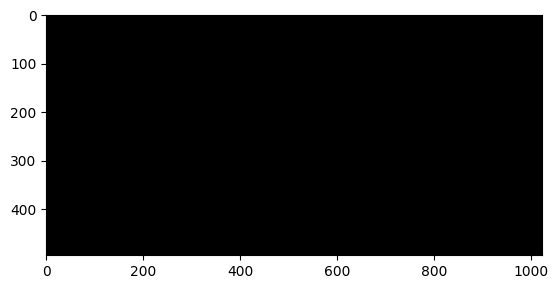

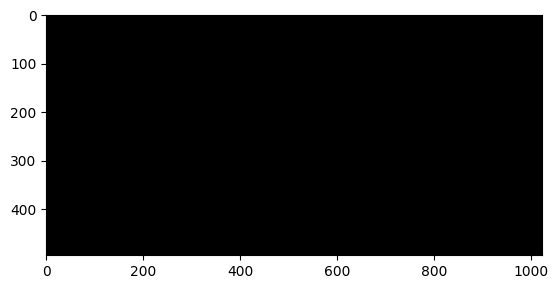

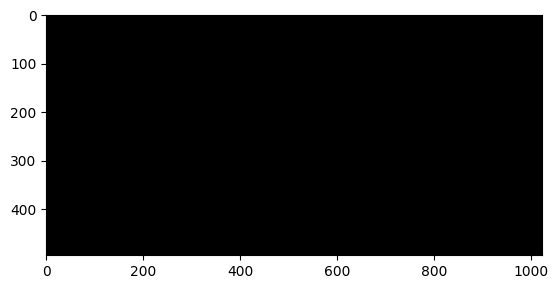

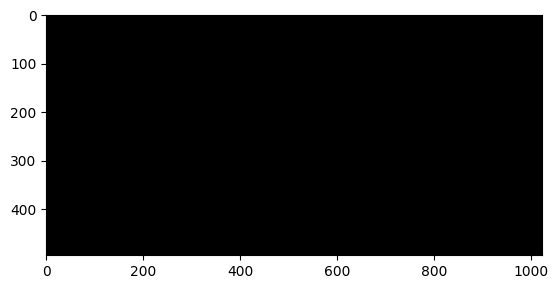

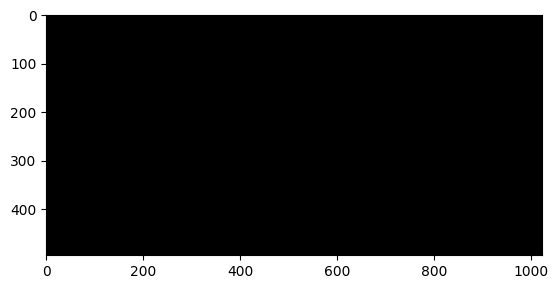

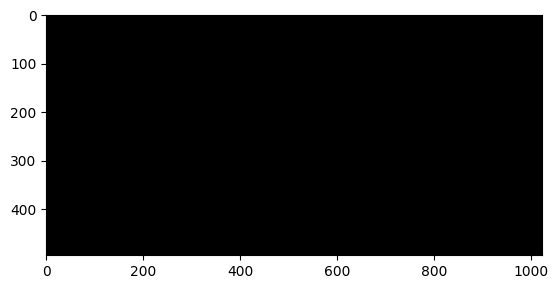

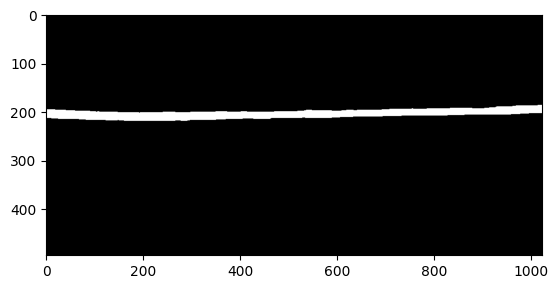

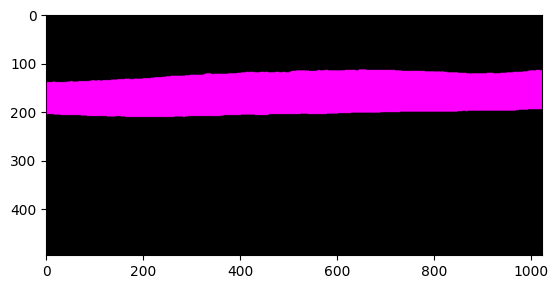

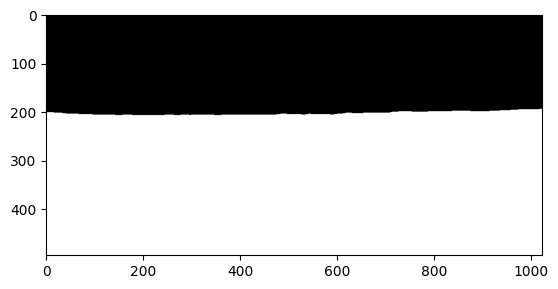

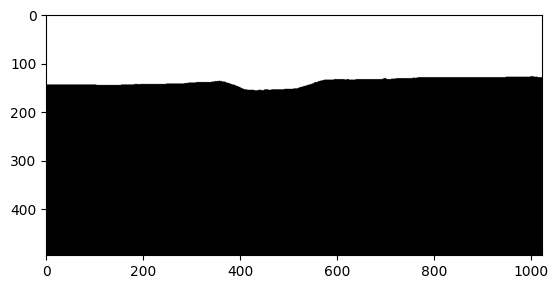

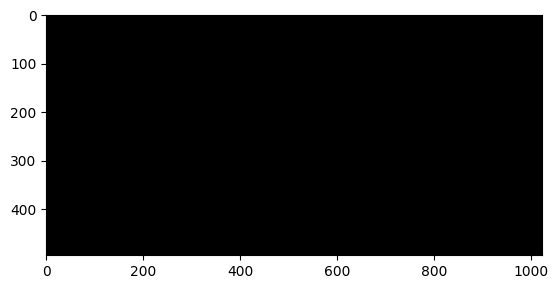

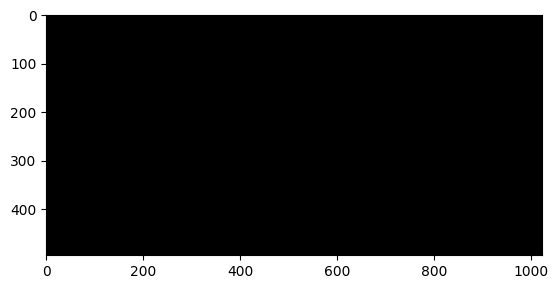

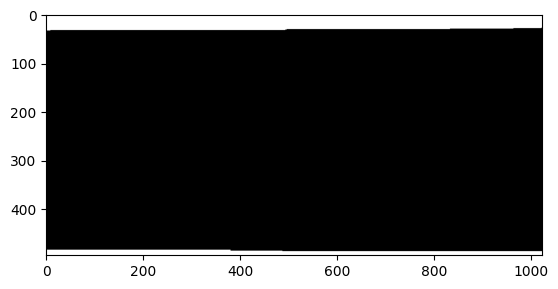

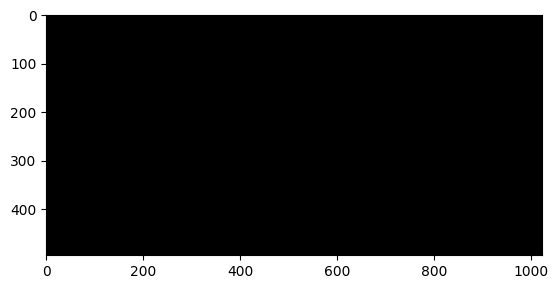

In [129]:
pattern = re.compile("^Segment\d+")

for vol_path, seg_path in zip(vol_paths, seg_paths):
    print(f"Name: {os.path.splitext(os.path.basename(vol_path))[0]}")

    vol = tif.imread(vol_path)
    seg, header = nrrd.read(seg_path)
    print(f"TIFF type: {type(vol)}, TIFF shape: {vol.shape}, SEG.NRRD type: {type(seg)}, SEG.NRRD shape: {seg.shape}")

    segment_colors = {k.split("_")[0]: v for k, v in header.items() if k.endswith("Color")}
    print(f"segment_colors: {segment_colors}")

    sorted_color_map = sorted(segment_colors.items(), key=lambda x: natural_sort_key(x[0]))
    print(f"sorted_color_map: {sorted_color_map}")

    _, sorted_colors = list(zip(*sorted_color_map))
    print(f"sorted_colors: {sorted_colors}")

    rgb_colors = [[round(255.*float(c)) for c in i.split(" ")] for i in sorted_colors]
    print(f"rgb_colors: {rgb_colors}")

    output = overlay_segments(seg, rgb_colors)


    for o in output:
        plt.figure()
        plt.imshow(o)






    # plt.figure(figsize=(5,5))
    # plt.imshow(seg[8, :, :, 10].T, cmap="gray")
    # plt.title("Manual Segmentation")
    # plt.axis("off")
    break
    